# Hyperparameter Optimisation with Scikit-Learn

In Machine Learning (ML) **hyperparameters** are parameters, which must be configured by the user - in contrast to **parameters**, which are learned in the training phase. This section demonstrates how ML hyperparameters can be optimized. First scikit-learn's `validation_curve` is applied to visualize the optimisation of a single hyperparameter. Then the joint optimisation of multiple hyperparameters is addressed by applying `GridSearch` and `RandomSearch` from scikit-learn.

In [1]:
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import validation_curve, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold
from matplotlib import pyplot as plt
import utilsJM # requires: import sys; sys.path.append('/path/to/utilsJM')

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Access data

In this notebook **regression models** are trained and evaluated by the example application **Estimation of rental bikes per day**. The task is to predict the daily count of rental bikes from features describing the weather situation and the date and season. The applied dataset is available from [UCI Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). After downloading and storing the corresponding .csv-file it can be accessed using *Pandas*:  

In [3]:
bikefile="../Data/bikeday.csv"
bikedf=pd.read_csv(bikefile,index_col=0)
bikedf.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


Each of the 731 rows (2years) corresponds to one day. 

**Feature Description:**

- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not 
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)

**Target:**

- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In our regression - experiments only *cnt* is applied as target value. The distinction into *casual* and *registered* can be ignored. 

Calculate descriptive statistics:

In [4]:
bikedf.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


## Configure Training- and Testdata
Columns 1 (season) to 11 (windspeed) are used as features. The target variable is the last column, i.e. the total count of rental bike per day. 

In [5]:
featureCols=bikedf.columns[1:-3]
print(featureCols)
targetCol=bikedf.columns[-1]
X=bikedf[featureCols].values
y=bikedf[targetCol].values

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')


The entire dataset, which comprises 731 days is split into training- and test-partitions. For later use the partioned datasets are saved persistently as Numpy arrays.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
np.save("../Data/Bike_x_train",X_train)
np.save("../Data/Bike_x_test",X_test)
np.save("../Data/Bike_y_train",y_train)
np.save("../Data/Bike_y_test",y_test)

## Train and test Random Forest

In [7]:
rf_regressor = RandomForestRegressor(n_estimators=30, max_depth=8, min_samples_split=2,random_state=1)
rf_regressor.fit(X_train, y_train)
print(rf_regressor)

RandomForestRegressor(max_depth=8, n_estimators=30, random_state=1)


The trained model is persistently saved as a [pickle](https://docs.python.org/2/library/pickle.html).

In [8]:
with open('../Data/rf_regressor_bike.pkl', 'wb') as f:
    pickle.dump(rf_regressor, f)

## Evaluation

In [9]:
# Evaluate performance of Random Forest regressor
y_pred = rf_regressor.predict(X_test)

In [10]:
title="Random Forest Regression"
utilsJM.determineRegressionMetrics(y_test,y_pred,title=title)

Random Forest Regression
Mean absolute error = 518.71
Mean squared error = 485439.08
Median absolute error = 412.14
R2 score = 0.88
Explained variance score = 0.88


## Feature importance

The [scikit-learn DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) calculates the importance of a feature as the normalized Gini importance. **Gini impurity** of a node $V$ in the decision tree is calculated as 

$$
Gini(V) = \sum\limits_{i \in L_V} p_i(1-p_i),
$$

where $L_V$ is the set of all labels that appear in the dataset $D(V)$ associated to node $V$ and $p_i$ is the probability for label $i$ in $D(V)$. Every time a split of a node is made on variable $m$ the gini impurity criterion for the two descendent nodes is less than the parent node. The decrease of gini impurity from node $V$ to its child nodes is the **gini importance** of variable $m$, which has been applied for the split.

Another criterion to measure feature importance is the **Information Gain**, which measures the decrease of **entropy** from one node $V$ to it's child nodes. **Entropy** of a node $V$ in the decision tree is calculated as 

$$
Entropy(V) = \sum\limits_{i \in L_V} p_i \log_2(p_i),
$$  

For Decision Trees and **all ensemble algorithms based on decision trees (e.g. Random Forests)** gini importance is used to measure feature importance.

For the trained RandomForest-model, the importance of all features can be accessed and displayed as follows:

In [11]:
importances = rf_regressor.feature_importances_
for f,i in zip(featureCols,importances):
    print(f,i)

season 0.04701345873969123
yr 0.28005609752956023
mnth 0.037969159695260046
holiday 0.0026660869191508976
weekday 0.012238145106364933
workingday 0.0023298065507938556
weathersit 0.024892207416323302
temp 0.39855221932074225
atemp 0.10156425774479184
hum 0.06175319403580362
windspeed 0.03096536694151787


It is also possible to access the feature importance of each tree in the ensemble. This is implemented in the code below in order to visualize the standard deviation of feature importance over all trees. 

In [12]:
importances = rf_regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_regressor.estimators_],axis=0)
print(std)

[0.03579741 0.02914722 0.01515451 0.00250772 0.0051406  0.00138624
 0.01697063 0.12878598 0.12677015 0.01700202 0.01441623]


For a better visualisation of the feature importances, the following function is applied:

In [13]:
def plot_feature_importances(feature_importances, title, feature_names,std="None"):
    
    # Normalize the importance values 
    feature_importances = 100.0 * (feature_importances / max(feature_importances))
    if std=="None":
        std=np.zeros(len(feature_importances))

    # Sort the values and flip them
    index_sorted = np.flipud(np.argsort(feature_importances))

    # Arrange the X ticks
    pos = np.arange(index_sorted.shape[0]) + 0.5

    # Plot the bar graph
    plt.figure(figsize=(16,10))
    plt.bar(pos, feature_importances[index_sorted], align='center',alpha=0.5,yerr=100*std[index_sorted])
    plt.xticks(pos, feature_names[index_sorted])
    plt.ylabel('Relative Importance')
    plt.title(title)
    plt.show()

Plot relative feature importances: 

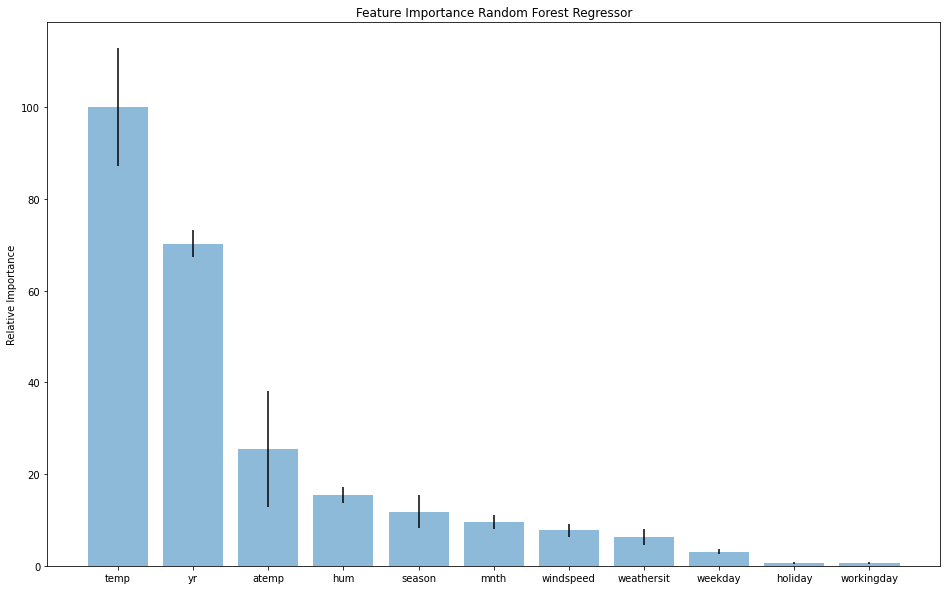

In [14]:
plot_feature_importances(rf_regressor.feature_importances_, 'Feature Importance Random Forest Regressor', featureCols,std)

## Visualize prediction error

There are different methods to analyse the difference between the true output and the predicted output. Below, two visualisations of this difference are demonstrated. First, for a set of successive instances a line of the true outputs and a line of the predicted output is plotted into the same figure. Then a histogram is calculated for the deviations $y_{predicted}-y_{true}$.

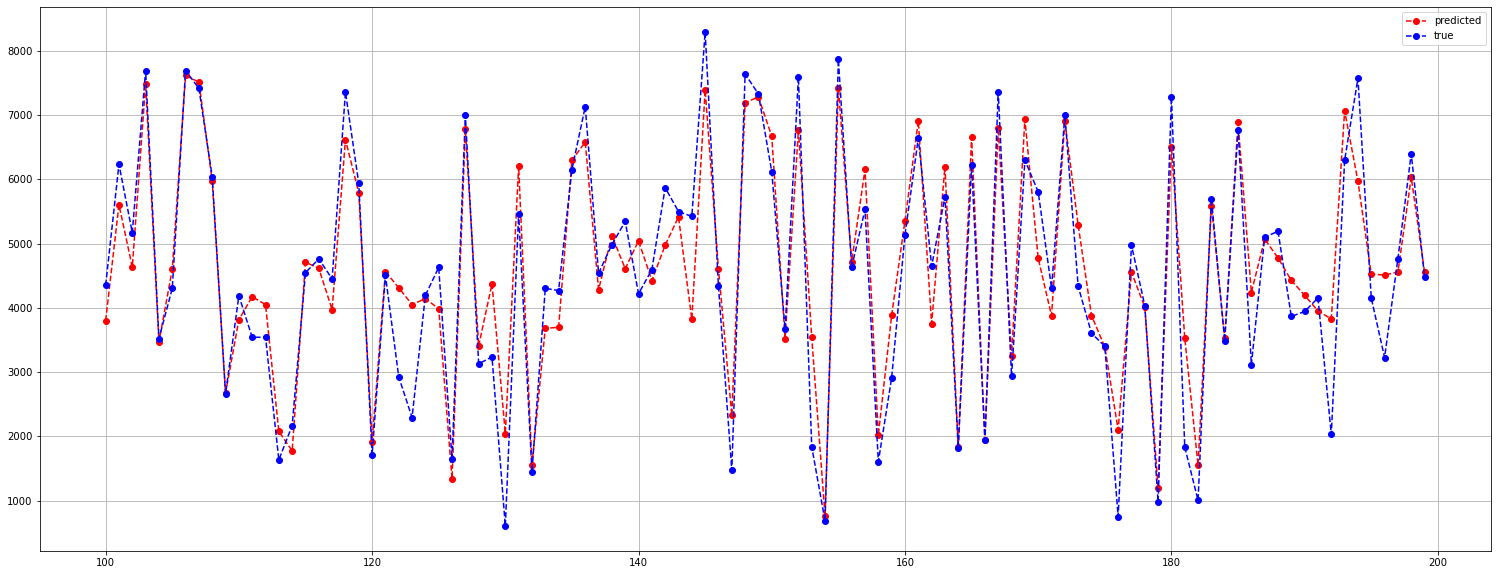

In [15]:
MIN=100
MAX=200
MAX=np.min([MAX,len(y_test)])
x_vals=np.arange(MIN,MAX)
y_pred_vals=y_pred[x_vals]
y_test_vals=y_test[x_vals]
plt.figure(figsize=(26,10))
plt.plot(x_vals,y_pred_vals,'ro--',label="predicted")
#plt.hold(True)
plt.plot(x_vals,y_test_vals,'bo--',label="true")
plt.grid(True)
plt.legend()
plt.show()

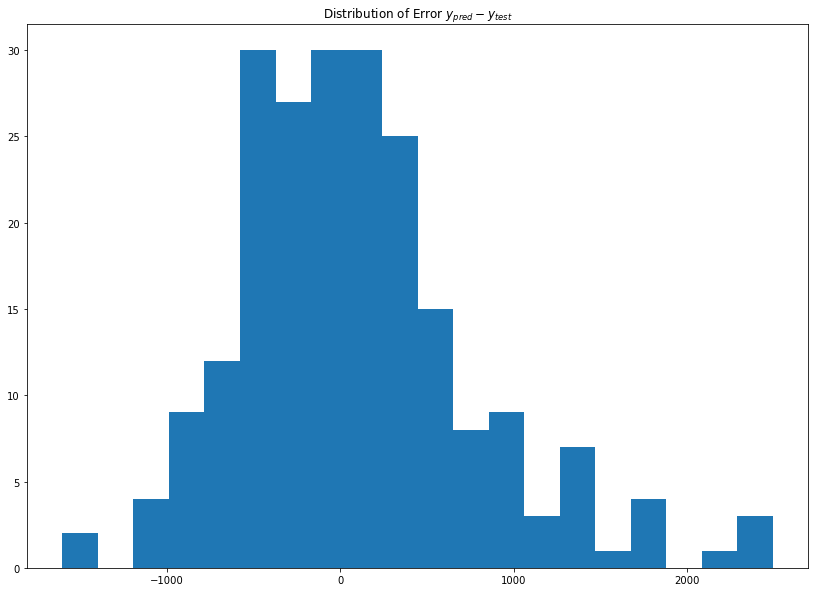

In [16]:
plt.figure(figsize=(14,10))
plt.hist(y_pred-y_test,bins=20)
plt.title("Distribution of Error $y_{pred}-y_{test}$")
plt.show()

## Hyperparameter Optimisation

In this subsection we address the task of finding the best hyperparameters for DecisionTree-Regressor. The set of all hyperparameters of this ML-algorithm is defined in the [scikit-learn docu of DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). Here, we are just interested in the hyperparameters

* `n_estimators`: the number of trees in the ensemble
* `max_depth`: the maximum depth of the tree
* `min_samples_split`: the minimum number of instances, required to further split a node

In the first subsection scikit-learn's `validation_curve()` is applied for visualisation of a single hyperparameter. Then `GridSearch` and `RandomSearch` are applied in order to jointly optimize a set of hyperparameters:

### Validation Curve

In [17]:
estimator_range=np.arange(20,160,20)
depth_range=np.arange(3,12)
min_leaf_range=np.arange(1,6)

Sometimes it is helpful to plot the influence of a single hyperparameter on the training- and the validation-score to find out whether the estimator is overfitting or underfitting for some hyperparameter values. For this the [scikit-learn function validation_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html) can be applied. As can be seen in the code cell below, the most important arguments of this functions are 

* the ML-algorithm (of class `estimator`), which shall be analysed (RandomForestRegressor in this case)
* the name of the hyperparameter of the applied ML-algorithm (`param_name`)
* the value range for the specified hyperparameter (`param_range`)
* the scoring-function that shall be applied (`neg_mean_absolute_error` in the example)

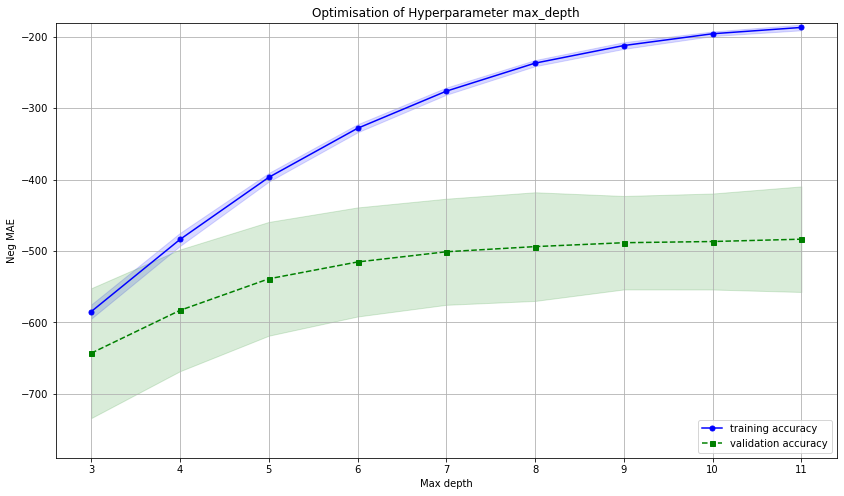

In [18]:
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2)
train_scores, test_scores = validation_curve(estimator=rf_regressor,
                                                     X=X_train,y=y_train,
                                                     param_name="max_depth", 
                                                     param_range=depth_range,cv=10,
                                                     scoring="neg_mean_absolute_error")
utilsJM.plot_evaluation_curve(depth_range,train_scores,test_scores,xlabel="Max depth",
                              xscale='linear',ylabel="Neg MAE")
plt.title("Optimisation of Hyperparameter max_depth")
plt.show()

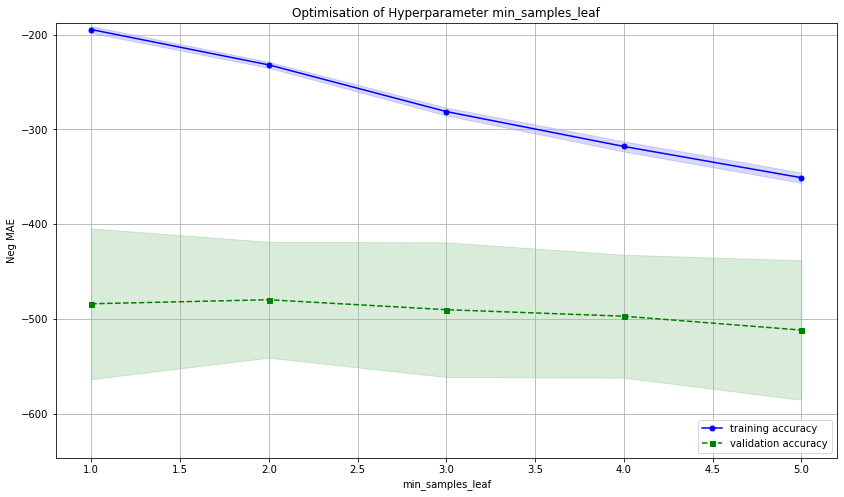

In [19]:
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2)
train_scores, test_scores = validation_curve(estimator=rf_regressor,
                                             X=X_train,y=y_train,
                                             param_name="min_samples_leaf", 
                                             param_range=min_leaf_range,cv=10,
                                             scoring="neg_mean_absolute_error")
utilsJM.plot_evaluation_curve(min_leaf_range,train_scores,test_scores,xlabel="min_samples_leaf",
                              xscale='linear',ylabel="Neg MAE")
plt.title("Optimisation of Hyperparameter min_samples_leaf")
plt.show()

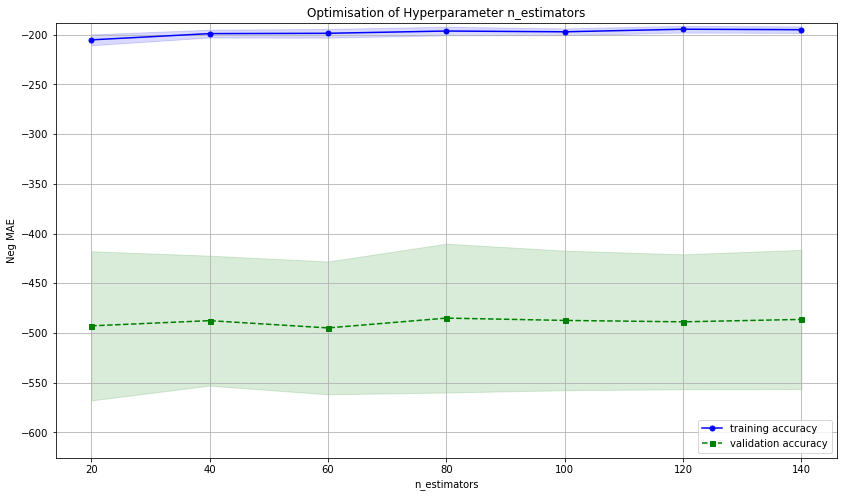

In [20]:
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2)
train_scores, test_scores = validation_curve(estimator=rf_regressor,
                                             X=X_train,y=y_train,
                                             param_name="n_estimators", 
                                             param_range=estimator_range,cv=10,
                                             scoring="neg_mean_absolute_error")
utilsJM.plot_evaluation_curve(estimator_range,train_scores,test_scores,
                              xlabel="n_estimators",xscale='linear',ylabel="Neg MAE")
plt.title("Optimisation of Hyperparameter n_estimators")
plt.show()

### Grid Search
[Scikit-learn's GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) provides an exhaustive search over specified parameter values for an ML-algorithm (class `estimator`).

In [21]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In this example, the best configuration of hyperparameters `max_depth`, `n_estimators` and `bootstrap` of a RandomForestRegresser shall be determined. For this we define the following parameter-grid:

In [22]:
param_grid = [{'max_depth': depth_range, 'n_estimators': estimator_range, 'bootstrap': [True,False]}]
param_grid

[{'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
  'n_estimators': array([ 20,  40,  60,  80, 100, 120, 140]),
  'bootstrap': [True, False]}]

As can be seen in the code-cell below, the defined parameter-grid is passed to the `GridSearchCV`-object, together with the ML-algorithm, the scoring function and the number of iterations of the cross-validation.

In [23]:
rf_regressor = RandomForestRegressor()
rfGS = GridSearchCV(estimator=rf_regressor, param_grid=param_grid,scoring='neg_mean_absolute_error',cv=10)
rfGS.fit(X_train,y_train)

KeyboardInterrupt: 

After the grid-search, the best configuration and the corresponding score can be accessed as follows:

In [24]:
print(rfGS.best_params_)
print(rfGS.best_score_)

{'bootstrap': True, 'max_depth': 11, 'n_estimators': 120}
-481.00662021110395


### Heuristic Search
A faster alternative for `GridSearchCV` is [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). In contrast to `GridSearchCV`, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by *n_iter*.

In [25]:
rf_regressor = RandomForestRegressor()
rfRandomSearch = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_grid[0],scoring='neg_mean_absolute_error',cv=10)
rfRandomSearch.fit(X_train,y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'n_estimators': array([ 20,  40,  60,  80, 100, 120, 140])},
                   scoring='neg_mean_absolute_error')

In [26]:
print(rfRandomSearch.best_params_)
print(rfRandomSearch.best_score_)

{'n_estimators': 80, 'max_depth': 9, 'bootstrap': True}
-491.84235546842376


As can be seen in the output above, in this example the best found configuration is only slightly worse than the best model, found by exhaustive grid-search.

## Compare best configuration found in GridSearch with original configuration

In [27]:
X_train=np.load("../Data/Bike_x_train.npy")
X_test=np.load("../Data/Bike_x_test.npy")
y_train=np.load("../Data/Bike_y_train.npy")
y_test=np.load("../Data/Bike_y_test.npy")

### Test best configuration found in GridSearchCV

In [28]:
rf_reg_best = rfGS.best_estimator_
rf_reg_best.oob_score=True
rf_reg_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=11, n_estimators=120, oob_score=True)

In [29]:
y_pred = rf_reg_best.predict(X_test)
title="Best Random Forest from GridSearch"
utilsJM.determineRegressionMetrics(y_test,y_pred,title=title)

Best Random Forest from GridSearch
Mean absolute error = 493.52
Mean squared error = 448355.22
Median absolute error = 363.35
R2 score = 0.89
Explained variance score = 0.89


### Test model with inital parameter configuration 

In [30]:
with open('../Data/rf_regressor_bike.pkl', 'rb') as f:
    rf_regressor2 = pickle.load(f)

In [31]:
#rf_reg_best = rfGS.best_estimator_
rf_regressor2.fit(X_train, y_train)
y_pred = rf_regressor2.predict(X_test)
title="Random Forest as applied in Evaluation 1 in this notebook"
utilsJM.determineRegressionMetrics(y_test,y_pred,title=title)

Random Forest as applied in Evaluation 1 in this notebook
Mean absolute error = 518.71
Mean squared error = 485439.08
Median absolute error = 412.14
R2 score = 0.88
Explained variance score = 0.88


## Compare different preprocessing configurations

In [32]:
from sklearn import compose

In [33]:
catFeats=[0,2,4,6]
pipe1 = Pipeline([
                 ('clf', RandomForestRegressor(n_estimators=300, max_depth=11,random_state=1)) 
                ])

pipe2 = Pipeline([('oneHot', compose.make_column_transformer((OneHotEncoder(categories="auto"), catFeats), remainder="passthrough"
)),
                 ('clf', RandomForestRegressor(n_estimators=300, max_depth=11,random_state=1)) 
                ])

pipe3 = Pipeline([('stdSc', StandardScaler(with_mean=True)),
                 ('clf', RandomForestRegressor(n_estimators=300, max_depth=11,random_state=1)) 
                ])
pipe4 = Pipeline([('oneHot', compose.make_column_transformer((OneHotEncoder(categories="auto"), catFeats), remainder="passthrough"
)),
                 ('stdSc', StandardScaler(with_mean=True)),
                 #('pca', PCA(n_components=2)),
                 ('clf', RandomForestRegressor(n_estimators=300, max_depth=11,random_state=1)) 
                ])
pipe5 = Pipeline([('oneHot', compose.make_column_transformer((OneHotEncoder(categories="auto"), catFeats), remainder="passthrough"
)),
                 ('stdSc', StandardScaler(with_mean=False)),
                 #('pca', PCA(n_components=2)),
                 ('clf', RandomForestRegressor(n_estimators=300, max_depth=11,random_state=1)) 
                ])
pipe6 = Pipeline([('oneHot', compose.make_column_transformer((OneHotEncoder(categories="auto"), catFeats), remainder="passthrough"
)),
                 ('stdSc', MinMaxScaler()),
                 #('pca', PCA(n_components=2)),
                 ('clf', RandomForestRegressor(n_estimators=300, max_depth=11,random_state=1)) 
                ])

scores = [
    cross_val_score(clf, X_train, y_train, scoring='neg_mean_absolute_error')
            for clf in [pipe1,pipe2,pipe3,pipe4,pipe5,pipe6]
    ]

In [34]:
for score,label in zip(scores, 
                       ['only Random Forest', 
                        'Random Forest+OneHotEncoding',
                        'Random Forest+Scaling with mean', 
                        'Random Forest+OneHot+StdScaling with mean',
                        'Random Forest+OneHot+StdScaling without mean',
                        'Random Forest+OneHot+MinmaxScaling',
                        ]
                       ):
    print("Accuracy: %5.2f (+/- %5.2f) \t %s "%(score.mean(), score.std(), label))

Accuracy: -493.56 (+/- 59.58) 	 only Random Forest 
Accuracy: -514.36 (+/- 63.08) 	 Random Forest+OneHotEncoding 
Accuracy: -492.51 (+/- 59.73) 	 Random Forest+Scaling with mean 
Accuracy: -514.26 (+/- 63.11) 	 Random Forest+OneHot+StdScaling with mean 
Accuracy: -514.49 (+/- 63.28) 	 Random Forest+OneHot+StdScaling without mean 
Accuracy: -514.56 (+/- 63.21) 	 Random Forest+OneHot+MinmaxScaling 


## ExtraTree Regression

In [35]:
estimator_range=np.arange(30,330,50)
depth_range=np.arange(3,12)
min_leaf_range=np.arange(1,4)

In [36]:
extra_regressor = ExtraTreesRegressor()
param_grid = [{'max_depth': depth_range, 'n_estimators': estimator_range, 'bootstrap': [True,False]}]

In [37]:
extRandomSearch = RandomizedSearchCV(estimator=extra_regressor, param_distributions=param_grid[0],scoring='neg_mean_absolute_error',cv=10)
extRandomSearch.fit(X_train,y_train)

RandomizedSearchCV(cv=10, estimator=ExtraTreesRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'n_estimators': array([ 30,  80, 130, 180, 230, 280])},
                   scoring='neg_mean_absolute_error')

In [38]:
print(rfRandomSearch.best_params_)
print(rfRandomSearch.best_score_)

{'n_estimators': 80, 'max_depth': 9, 'bootstrap': True}
-491.84235546842376


In [39]:
catFeats=[0,2,4,6]
pipe1 = Pipeline([
                 ('clf', ExtraTreesRegressor(n_estimators=200, max_depth=7,random_state=1)) 
                ])

pipe2 = Pipeline([('oneHot', compose.make_column_transformer((OneHotEncoder(categories="auto"), catFeats), remainder="passthrough"
)),
                 ('clf', ExtraTreesRegressor(n_estimators=200, max_depth=7,random_state=1)) 
                ])

pipe3 = Pipeline([('stdSc', StandardScaler(with_mean=True)),
                 ('clf', ExtraTreesRegressor(n_estimators=200, max_depth=7,random_state=1)) 
                ])
pipe4 = Pipeline([('oneHot', compose.make_column_transformer((OneHotEncoder(categories="auto"), catFeats), remainder="passthrough"
)),
                 ('stdSc', StandardScaler(with_mean=True)),
                 #('pca', PCA(n_components=2)),
                 ('clf', ExtraTreesRegressor(n_estimators=200, max_depth=7,random_state=1)) 
                ])
pipe5 = Pipeline([('oneHot', compose.make_column_transformer((OneHotEncoder(categories="auto"), catFeats), remainder="passthrough"
)),
                 ('stdSc', StandardScaler(with_mean=False)),
                 #('pca', PCA(n_components=2)),
                 ('clf', ExtraTreesRegressor(n_estimators=200, max_depth=7,random_state=1)) 
                ])
pipe6 = Pipeline([('oneHot', compose.make_column_transformer((OneHotEncoder(categories="auto"), catFeats), remainder="passthrough"
)),
                 ('stdSc', MinMaxScaler()),
                 #('pca', PCA(n_components=2)),
                 ('clf', ExtraTreesRegressor(n_estimators=200, max_depth=7,random_state=1))
                ])

scores = [
    cross_val_score(clf, X_train, y_train, scoring='neg_mean_absolute_error')
            for clf in [pipe1,pipe2,pipe3,pipe4,pipe5,pipe6]
    ]

In [40]:
for score,label in zip(scores, 
                       ['only Extra Trees', 
                        'Extra Trees+OneHotEncoding',
                        'Extra Trees+Scaling with mean', 
                        'Extra Trees+OneHot+StdScaling with mean',
                        'Extra Trees+OneHot+StdScaling without mean',
                        'Extra Trees+OneHot+MinmaxScaling',
                        ]
                       ):
    print("Accuracy: %5.2f (+/- %5.2f) \t %s "%(score.mean(), score.std(), label))

Accuracy: -482.83 (+/- 52.73) 	 only Extra Trees 
Accuracy: -513.89 (+/- 38.12) 	 Extra Trees+OneHotEncoding 
Accuracy: -482.83 (+/- 52.73) 	 Extra Trees+Scaling with mean 
Accuracy: -513.89 (+/- 38.12) 	 Extra Trees+OneHot+StdScaling with mean 
Accuracy: -513.89 (+/- 38.12) 	 Extra Trees+OneHot+StdScaling without mean 
Accuracy: -513.89 (+/- 38.12) 	 Extra Trees+OneHot+MinmaxScaling 
